# JuliaCon - MMM Demo

In [2]:
using Pkg; Pkg.activate(".")

  Activating project at `~/Documents/julia-con-2022/MediaMixModellingDemo`


In [3]:
using LinearAlgebra
using Plots, StatsPlots
using Plots.PlotMeasures
using Random
using StatsBase

In [4]:
using CSV,DataFrames,DataFramesMeta,Chain,TabularDisplay
using Dates
using Splines2,Printf
using TableTransforms
using CategoricalArrays
using ShiftedArrays
using Parameters

In [5]:
using Turing, Distributions
import AdvancedHMC; const AHMC = AdvancedHMC;
# using Turing: Variational
using LinearAlgebra
using MCMCChains
import Optim
import Metaheuristics

In [6]:
using BenchmarkTools

In [7]:
using Logging

In [8]:
# Plots.default(fmt=:png)
ENV["LINES"]=200
ENV["COLUMNS"]=600
Threads.nthreads();

4

In [9]:
using Revise

In [10]:
includet("src/data_generation.jl")
includet("src/feature_engineering.jl")
includet("src/marketing_transformations.jl")
includet("src/model_definition.jl")
includet("src/evaluation_stats.jl")
includet("src/evaluation_calculations.jl")
includet("src/evaluation_plots.jl")
includet("src/budget_optimization.jl")

## Generate

┌ Info: INDEX with 105 observations generated (random seed=0)
└ @ Main In[12]:128
┌ Info: TREND: Trend offset of 0.4 / Total growth of 0.2
└ @ Main In[12]:136
┌ Info: SEASONALITY: Series with periods 4 generated
└ @ Main In[12]:151
┌ Info: HOLIDAYS: Number of days: 5
│  Average effect: -0.2
│  Total effect: -1.1
└ @ Main In[12]:163
┌ Info: EVENTS: 0 events generated with coefficients: 0
└ @ Main In[12]:177
┌ Info: Marketing Variables: 
│ (label = "facebook_S", mean = 0.4, std = 0.2, sparsity = 1.0, decay_rate = 0.5, halfpoint = 0.4, slope = 1.5, unit_scale_ratio = 0.05, coef = 2.0) |
│  (label = "tv_S", mean = 0.8, std = 0.2, sparsity = 0.7, decay_rate = 0.8, halfpoint = 0.8, slope = 0.9, unit_scale_ratio = 0.1, coef = 1.3) |
│  (label = "search_S", mean = 0.5, std = 0.3, sparsity = 1.0, decay_rate = 0.05, halfpoint = 0.5, slope = 2.0, unit_scale_ratio = 0.05, coef = 2.5)
│ ROAS: facebook_S: 2.0 | tv_S: 1.3 | search_S: 2.5
└ @ Main In[12]:196
┌ Info: CONTEXT: Number of vars: 3 Coefs: 0

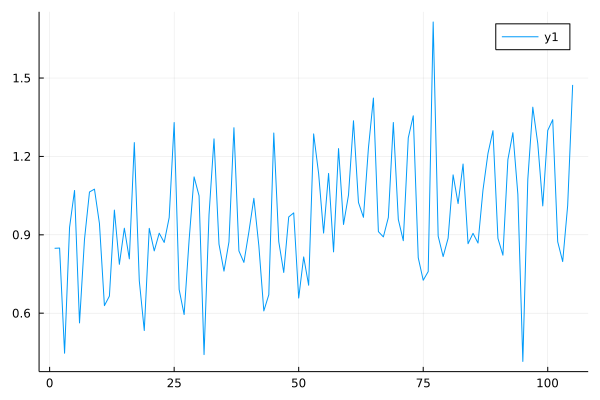

In [13]:
Y,X,col_names=create_dataset("2020-02-01",105,0);
y=sum.(eachrow(Y))
plot(y)

# Modelling 

In [ ]:
# Let's apply standard notation of df being the source of data
df=X
df[!,:revenue]=vec(y);

In [15]:
### Y transform
target_label=:revenue
y_true=df[!,target_label]
y_std,pipe_cache_y=standardize_by_max(select(df,target_label))
y_std=y_std[!,1]

# define revert function
revert_pipe_y = y->revert(MinMax(), (;y),pipe_cache_y)

### FEATURES
# positive coefficient, not transformed (saturated etc)
cols_organic=["newsletters"]
X_org,pipe_cache_org=standardize_by_max(convert.(Float64,df[!,cols_organic]))

# positive coeffcients, transformed
cols_spend=col_names.cols_spend
X_spend,pipe_cache_spend=standardize_by_max(convert.(Float64,df[!,cols_spend]))

# any coefficient
cols_context=[c for c in col_names.cols_context if !(c in cols_organic)]
X_context,pipe_cache_context=standardize_by_zscore(convert.(Float64,df[!,cols_context]))

# categorical
cols_cat=["events"]
cat_levels=1
# must be a vector
X_cat=df[!,cols_cat[1]] .|> levelcode;

# No transformation
cols_hols=["hols_ind"]
X_hols=df[!,cols_hols]

X_feat=hcat(X_spend,X_org,X_context);

time_std=df.time_std
@show time_std|>size time_std|>extrema

# a trick to fit changing trends etc.
X_trend=Splines2.bs(time_std,df=3,boundary_knots=(-eps(),1+eps()));
@show X_trend|>size X_trend|>extrema

seasonality_arr=[(4/(length(time_std)-1),3,"4")]
X_seas=generate_seasonality_features(time_std, seasonality_arr);
first(X_seas)

time_std |> size = (105,)
time_std |> extrema = (0.0, 1.0)
X_trend |> size = (105, 3)
X_trend |> extrema = (1.0947644252537619e-47, 0.9999999999999993)


DataFrameRow
 Row │ seasonality4_01  seasonality4_02  seasonality4_03  seasonality4_04  seasonality4_05  seasonality4_06 
     │ Float64          Float64          Float64          Float64          Float64          Float64         
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │             1.0              1.0              1.0              0.0              0.0              0.0

## Stage 1 - Prophet-like model

Let's fit a model to the trend, seasonality and holidays
We do not adstock/saturate the marketing spend at this stage - just provide as is

In [16]:
p1=ParamsStage1()

ParamsStage1
  scales_trend_offset: Float64 0.45741119137901
  scales_growth_trend: Float64 1.737099382015156
  scales_trend: Float64 0.2
  scales_hols: Float64 0.3
  scales_seas: Array{Float64}((6,)) [0.19729680990437276, 0.14016643304989512, 0.1972968099043728, 0.1991669636554864, 10.0, 0.1991669636554864]
  scales_feat: Array{Float64}((6,)) [0.6683402641297568, 0.3599725313078623, 0.5322260537385635, 0.4944082052753412, 0.1408323105891291, 0.1408323105891291]
  scales_noise: Float64 0.2
  cat_levels: Int64 1


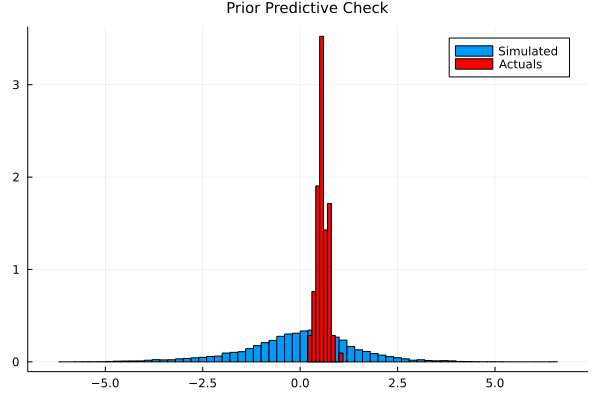

In [17]:
# Do not provide X_trend if your trend is simple
# It could overfit - there is a growth term, an offset and a seasonality already! 
# Use it on complicated datasets / with larger datasets
model_orig_stage1=model_stage1a(time_std,nothing, 
    X_hols|>Matrix,X_seas|>Matrix,
    X_feat|>Matrix,X_cat,p1);
cond_model_stage1=model_orig_stage1 | (;y=y_std);

y_prior=mapreduce(x->rand(model_orig_stage1).y,hcat,1:100)|>vec
plot_prior_predictive_histogram(y_std,y_prior,ParamsPlot())

In [18]:
# used to benchmark implementation of the core function
@btime cond_model_stage1.f(
    cond_model_stage1,
    Turing.VarInfo(cond_model_stage1),
    Turing.SamplingContext(
        Random.GLOBAL_RNG, Turing.SampleFromPrior(), cond_model_stage1.context,
    ),
    cond_model_stage1.args...,
);

  90.291 μs (888 allocations: 69.17 KiB)


### NUTS

In [19]:
max_depth=10
chain_stage1 = sample(cond_model_stage1, NUTS(300,0.65;max_depth),MCMCSerial(),100,1) 

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/simljx/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
Sampling (Chain 1 of 1): 100%|██████████████████████████| Time: 0:00:03


Chains MCMC chain (100×28×1 Array{Float64, 3}):

Iterations        = 301:1:400
Number of chains  = 1
Samples per chain = 100
Wall duration     = 12.2 seconds
Compute duration  = 12.2 seconds
parameters        = growth_trend, alpha[1], beta_hols[1], beta_seas[1], beta_seas[2], beta_seas[3], beta_seas[4], beta_seas[5], beta_seas[6], beta_feat[1], beta_feat[2], beta_feat[3], beta_feat[4], beta_feat[5], beta_feat[6], sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ess_per_sec 
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64       Float64 

  growth_trend    0.1069    0.0227     0.0023    0.0026    70.9487    1.0045        5.8155
      alpha[1]    0.4318    0.0284     0.0028    0.0032    61.6059    1.0068 

In [20]:
quick_nuts_diagnostics(chain_stage1)

Acceptance rate is: 81.9%
Number of Ham energy errors: 29
Number of all numerical errors: 0.0
Number of transitions that exceeded max depth of 10: 0


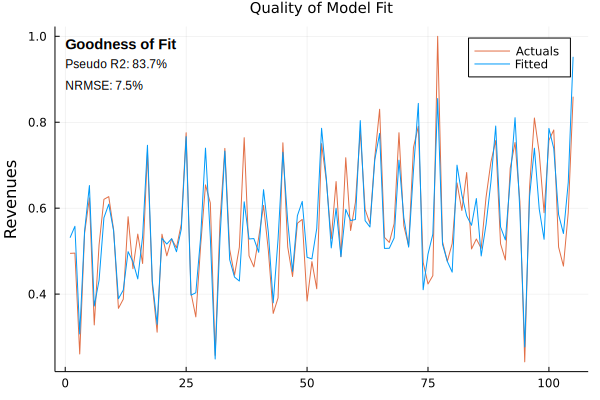

In [47]:
pred_vals_stage1 = predict(model_orig_stage1, chain_stage1,include_all=false);
y_pred_stage1=mean(pred_vals_stage1.value.data,dims=(1,3))|>vec;
plot_model_fit_by_period(y_std,y_pred_stage1,ParamsPlot())

### MAP (Alternative)
If NUTS is taking long time, you can just run MAP and use the below chain object for the stage1fit (it tends to be good enough)

In [48]:
# @time map_estimate = Optim.optimize(cond_model, MAP())

In [49]:
# dim=size(map_estimate.values,1)
# chain_map=Chains(repeat(reshape(collect(map_estimate.values),1,dim,1),outer=(100,)),
#             names(map_estimate.values)[1]);
# pred_vals_map = predict(model_orig, chain_map,include_all=false);
# y_pred_map=mean(pred_vals_map.value.data,dims=(1,3))|>vec;

# @printf("R2: %.1f%% \n",myr2(y_std,y_pred_map)*100)
# @printf("RMSE: %.1f \n",rmse(y_std,y_pred_map))
# @printf("NRMSE: %.1f%% \n",nrmse(y_std,y_pred_map)*100)

In [50]:
# chain_stage1=chain_map

## Stage 2 - Marketing drivers

Let's use the fit from the first stage and focus mostly on the marketing variables (including their adstock/saturation transformations)

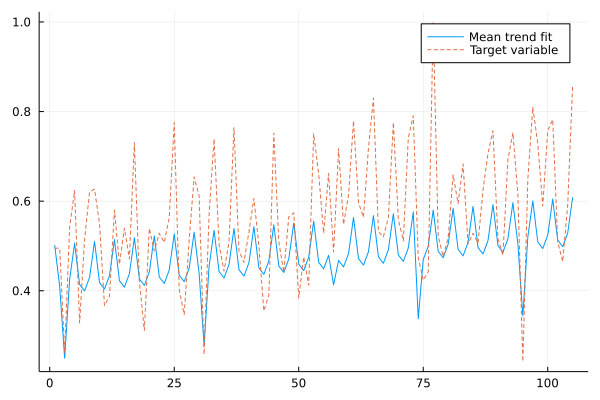

In [73]:
stage1_fit=generated_quantities(model_orig_stage1,Chains(chain_stage1,:parameters));
stage1_fit=mean([hcat(tup.mu_trend,tup.mu_hols,tup.mu_seas,tup.mu_cat) for tup in stage1_fit]);

plot(sum(stage1_fit,dims=2)|>vec,label="Mean trend fit")
plot!(y_std,label="Target variable",linestyle=:dash)

### Model

In [74]:
p2=ParamsStage2()

ParamsStage2
  scales_trend_offset: Float64 0.3
  scales_trend: Float64 0.2
  scales_noise: Float64 0.3
  scales_context: Array{Float64}((2,)) [0.1408323105891291, 0.1408323105891291]
  scales_org: Array{Float64}((1,)) [0.4944082052753412]
  decay_rate_alphas: Array{Int64}((3,)) [10, 20, 1]
  decay_rate_betas: Array{Int64}((3,)) [10, 10, 20]
  adspend_mean_nonzero: Array{Float64}((3,)) [0.4851587722373962, 0.7541554987714079, 0.5017887307476014]
  adspend_median: Array{Float64}((3,)) [0.4516153680390291, 0.5833326970854545, 0.46830338754026535]
  locs_spend_halfmaxpoint: Array{Float64}((3,)) [0.4851587722373962, 0.7541554987714079, 0.5017887307476014]
  scales_spend_halfmaxpoint: Array{Float64}((3,)) [0.3, 0.3, 0.3]
  units_ratio_spend_to_y: Array{Float64}((3,)) [0.02444516282338278, 0.058327761869252794, 0.029163880934626397]
  factor_to_roas_of_one: Array{Float64}((3,)) [0.04889032564676556, 0.11665552373850559, 0.058327761869252794]


### NUTS

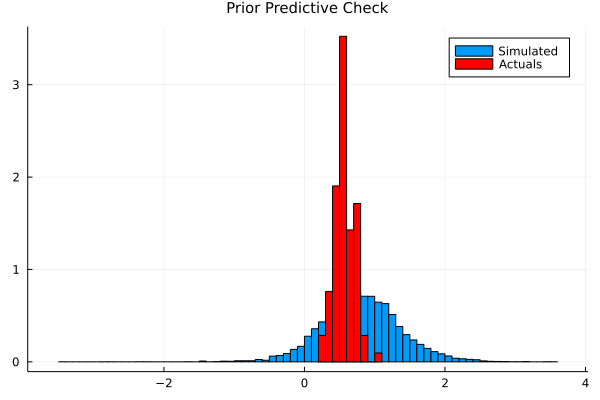

In [75]:
model_orig=model_stage2a(time_std,stage1_fit,X_spend|>Matrix,X_org|>Matrix,X_context|>Matrix,p2);
cond_model=model_orig | (;y=y_std);

y_prior=mapreduce(x->rand(model_orig).y,hcat,1:100)|>vec
plot_prior_predictive_histogram(y_std,y_prior,ParamsPlot())

In [76]:
# used to benchmark implementation of the core function

@btime cond_model.f(
    cond_model,
    Turing.VarInfo(cond_model),
    Turing.SamplingContext(
        Random.GLOBAL_RNG, Turing.SampleFromPrior(), cond_model.context,
    ),
    cond_model.args...,
);

  357.333 μs (4919 allocations: 198.94 KiB)


In [77]:
max_depth=10
metricT=AHMC.DiagEuclideanMetric 

with_logger(NullLogger()) do 
    global chain = sample(cond_model, NUTS(500,0.65;max_depth,metricT),MCMCSerial(),500,1) 
end

Sampling (Chain 1 of 1): 100%|██████████████████████████| Time: 0:00:40


Chains MCMC chain (500×33×1 Array{Float64, 3}):

Iterations        = 501:1:1000
Number of chains  = 1
Samples per chain = 500
Wall duration     = 50.57 seconds
Compute duration  = 50.57 seconds
parameters        = trend_offset, beta_trend[1], beta_trend[2], beta_trend[3], beta_trend[4], beta_context[1], beta_context[2], beta_spend[1], beta_spend[2], beta_spend[3], beta_org[1], decay_rate[1], decay_rate[2], decay_rate[3], slope[1], slope[2], slope[3], halfmaxpoint[1], halfmaxpoint[2], halfmaxpoint[3], sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
       parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
           Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

     trend_offset   -0.0452    0.0825     0.0037    0.0048    281.9016 

In [78]:
quick_nuts_diagnostics(chain)

Acceptance rate is: 82.2%
Number of Ham energy errors: 193
Number of all numerical errors: 0.0
Number of transitions that exceeded max depth of 10: 0


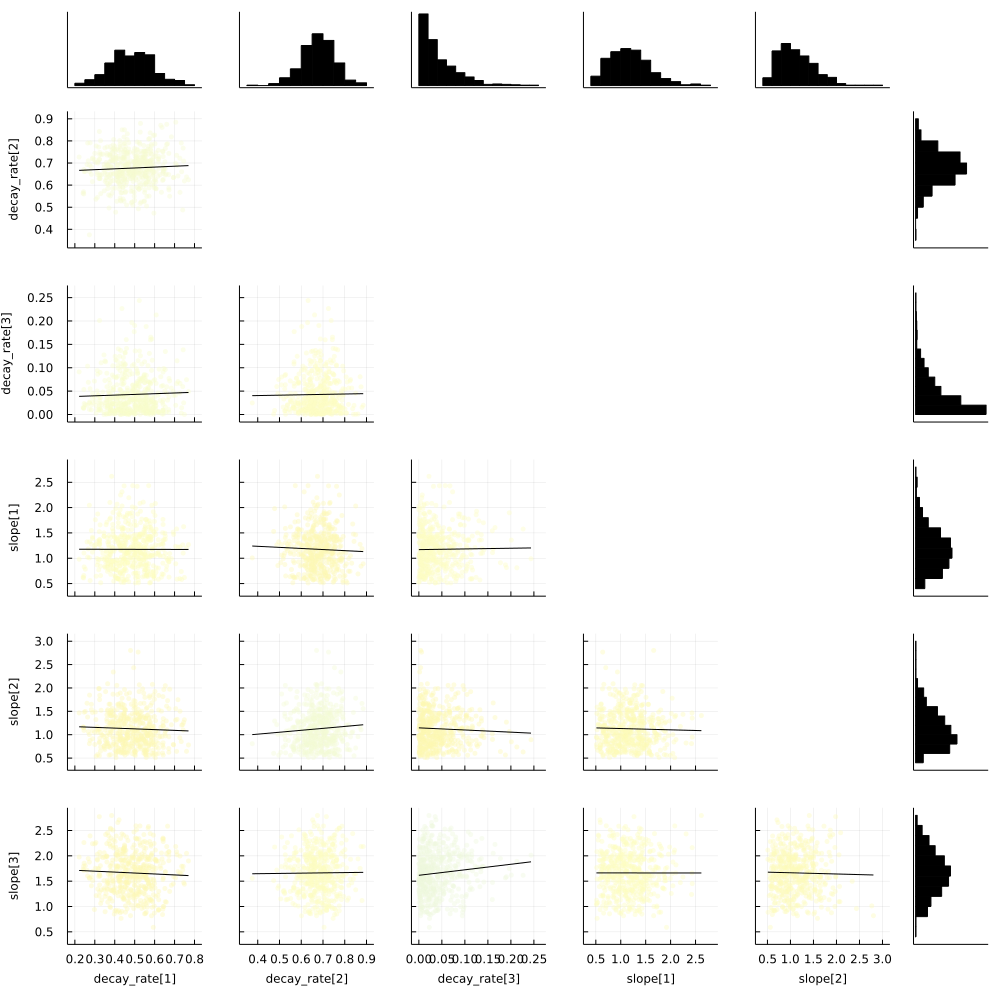

In [79]:
# Diagnostics if the parameter space has been properly explored
corner(chain[[namesingroup(chain,"slope")...,namesingroup(chain,"decay_rate")...]], 
    guidefontsize=8,size=(1000,1000))

In [80]:
# Diagnostics if the parameter space has been properly explored
corner(chain[[namesingroup(chain,"slope")...,namesingroup(chain,"beta_spend")...,Symbol("beta_org[1]")]], 
    guidefontsize=8,size=(1000,1000))

# Evaluation

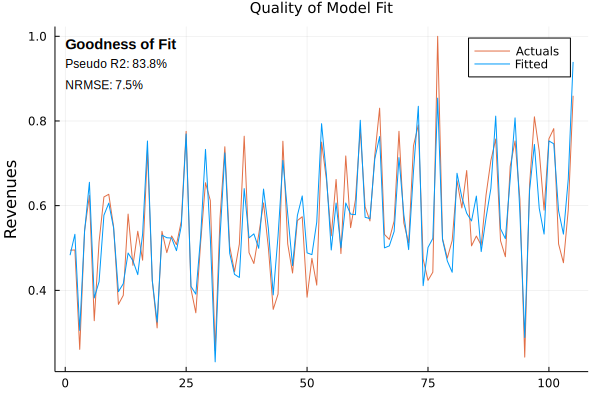

In [81]:
# Generate predictive posterior
pred_vals = predict(model_orig, chain,include_all=false);
y_pred=mean(pred_vals.value.data,dims=(1,3))|>vec;

plot_model_fit_by_period(y_std,y_pred,ParamsPlot())

In [82]:
stage2_fit_allsamples=generated_quantities(model_orig,Chains(chain,:parameters));
# TO DO: Contributions can become negative in some cases!! 

## Model 1-pager

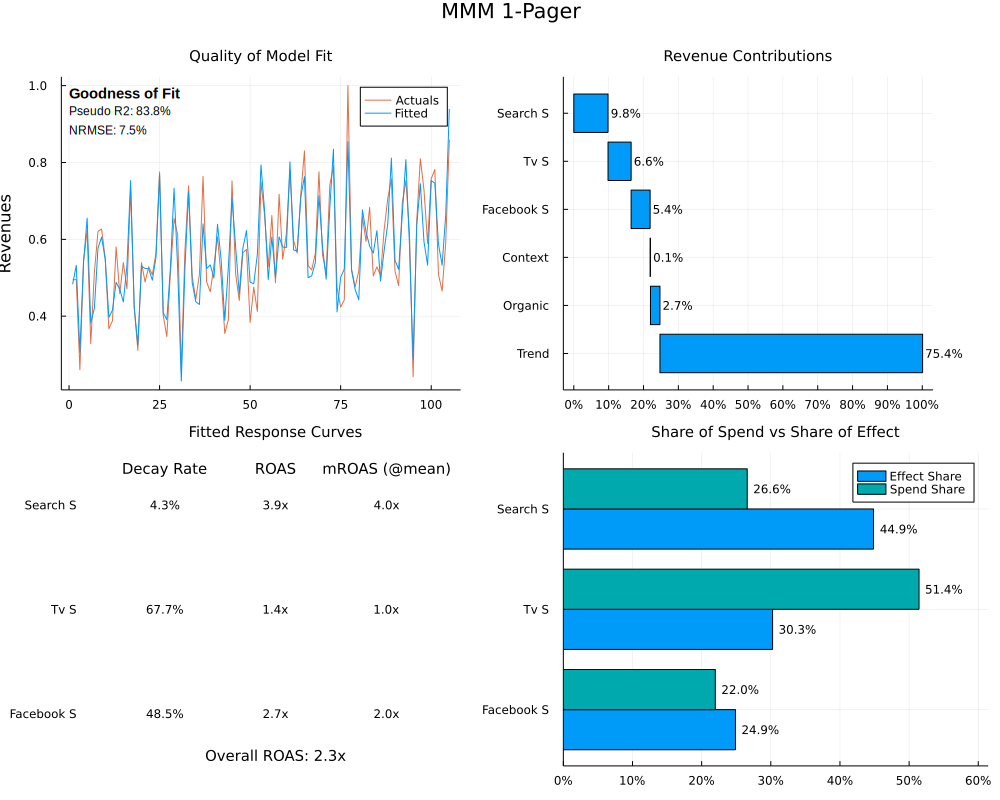

In [105]:
pplot=ParamsPlot();

# Header
pl0 = plot(title = "MMM 1-Pager", grid = false, showaxis = false, ticks=false,bottom_margin = -0Plots.px)

###
pl1=plot_model_fit_by_period(y_std,y_pred,pplot)

###
effect_share_mean=mean([
    hcat(sum(hcat(tup.mu_trend,tup.mu_org,tup.mu_context),dims=1)...,tup.mu_spend_by_var) 
    for tup in stage2_fit_allsamples]);

cols=["Trend","Organic","Context",cols_spend...] .|> prettify_labels

pl2=plot_contributions(effect_share_mean,cols,pplot)

### 
# extract fitted geometric decay rates
decay_rates=getflatsamples(chain,"decay_rate")|>x->mean(x,dims=1)|>vec
# calculate roas across the whole period
roass=calc_roas(stage2_fit_allsamples,X_spend,p2.units_ratio_spend_to_y)
# calculate mroas at mean spend of each variable with delta of 0.01
mroas_at_means=[calc_mroas(p2.adspend_mean_nonzero[idx],0.01,chain,p2,idx)[1] for idx in 1:length(cols_spend)]

# Total ROAS
X_spend_raw=revert(MinMax(),X_spend,pipe_cache_spend)
roas_total=calc_roas_total(stage2_fit_allsamples,X_spend_raw)

cols=prettify_labels.(cols_spend)
    
pl3=plot_response_curves_table(decay_rates,roass,mroas_at_means,cols,roas_total,pplot)

###  
effect_share_mean=[tup.mu_spend_by_var for tup in stage2_fit_allsamples] |> mean |> percentage_share |> vec
spend_share=revert(MinMax(),X_spend,pipe_cache_spend) |> Matrix |> sum_columns |>  percentage_share |> vec
cols=prettify_labels.(cols_spend)
    
pl4=plot_effects_vs_spend(effect_share_mean,spend_share,cols,pplot)


####################
# 1-Pager

plot_array=[pl0,pl1,pl2,pl3,pl4]

# Save each step
for i in 1:5
    pl=plot_mmm_one_pager(plot_array,i,pplot)
    # savefig(pl,joinpath(pwd(),"presentation","assets","mmm-1pager_$(i).png"))
end;
# show final
plot_mmm_one_pager(plot_array,5,pplot)

# Optimization

Let's optimize the marketing budget

In [106]:
# Runs on the whole period at the moment
optim_start=df.dt|>minimum
optim_end=df.dt|>maximum
optim_mask=trues(nrow(df)) 

@assert ((df.dt .>= optim_start) .&& (df.dt .<= optim_end) )|>all
@assert sum(optim_mask)==nrow(df) "Optimization on sub-periods not implemented yet!"

## Metaheuristics loop

In [108]:
# Inputs
chain_optim=Chains(chain,:parameters)
spend_prev_trf=X_spend|>Matrix|>sum_columns|>vec
factor_to_scale_spend_to_orig=getindex.(pipe_cache_spend,:xh)
simulations_prev=simulate_revenues_summed(chain_optim,model_orig,optim_mask)

# boundaries on possible solution
lower_bound = 0.5*ones(length(cols_spend)) # max 50% reduction
upper_bound = 1.5*ones(length(cols_spend)) # max 50% increase
bounds = [lower_bound upper_bound]'

# Bayesian Decision Theory -- how to weigh the outcomes across the posterior distribution
# define a simple assymetric (risk-averse) loss function
loss_func(x)=x>0 ? 0.5x : x
# plot(loss_func,-2,2)

objective_func=generate_objective_func(
    chain_optim,model_orig,Matrix(X_spend),optim_mask,
    spend_prev_trf,factor_to_scale_spend_to_orig,
    loss_func,simulations_prev,bounds)

#171 (generic function with 1 method)

In [109]:
# time_limit is in seconds
# debug = true if you want to see each iteration
# parallel_evaluation = true if you have batch-enabled objective function (see `objective_func_parallel`)
options = Metaheuristics.Options(time_limit=60.,debug=false,parallel_evaluation=false)

@time result = Metaheuristics.optimize(objective_func, bounds, Metaheuristics.WOA(N=30,options=options))

 61.321223 seconds (895.35 M allocations: 37.928 GiB, 5.95% gc time, 0.04% compilation time)


+=========== RESULT ==========+
  iteration: 26
    minimum: -0.895471
  minimizer: [1.3276005153967454, 0.6029980069846745, 1.5]
    f calls: 780
  feasibles: 27 / 30 in final population
 total time: 61.3217 s
stop reason: Maximum time exceeded.
+============================+

In [110]:
@show Metaheuristics.minimum(result)
@show Metaheuristics.minimizer(result)

loss_optim=Metaheuristics.minimum(result)
budget_multiplier_optim=Metaheuristics.minimizer(result);

Metaheuristics.minimum(result) = -0.8954707330542996
Metaheuristics.minimizer(result) = [1.3276005153967454, 0.6029980069846745, 1.5]


In [111]:
### Prepare intermediary results for evaluation

simulations_optim,X_spend_optim_trf,spend_mutliplier_optim=workflow_budget_to_simulation(
                    chain_optim,model_orig,
                    X_spend|>Matrix,
                    optim_mask,spend_prev_trf,
                    factor_to_scale_spend_to_orig,budget_multiplier_optim)

# replace the old spend with new and run the simulation
model_args_new=merge(model_orig.args,(;X_spend=X_spend_optim_trf))
simulations_optim=generated_quantities(model_stage2a(model_args_new...),chain_optim);

# Simulated revenues: dim_obs X dim_samples
simulation_optim_trf=hcat([s.y for s in simulations_optim]...) |> x->@view(x[optim_mask,:])

# Simulated marketing effect: dim_obs X dim_samples
spend_effect_trf=hcat([s.mu_spend for s in simulations_optim]...) |> x->@view(x[optim_mask,:])


# Careful: X_spend_optim_trf is not subset to optim_mask!
# Add column names
X_spend_optim_trf=DataFrame(X_spend_optim_trf,names(X_spend))
X_spend_optim_raw=revert(MinMax(),X_spend_optim_trf,pipe_cache_spend);

In [112]:
#############################
# Optimization smell tests

# check that the ad spend is the same 
check_total_spend1=revert(MinMax(),X_spend,pipe_cache_spend)|>Matrix|>sum
@assert check_total_spend1 ≈ sum(Matrix(X_spend_optim_raw)) "Error: Ad spend has changed ($(check_total_spend1) vs $(sum(Matrix(X_spend_optim_raw))))"

check_total_spend2=sum(Matrix(df[!,cols_spend]))
@assert check_total_spend2 ≈ sum(Matrix(X_spend_optim_raw)) "Error: Ad spend has changed ($(check_total_spend2) vs $(sum(Matrix(X_spend_optim_raw))))"

# check spend_multiplier that it's within bounds
@assert all(bounds'[:,1] .<= spend_mutliplier_optim .<= bounds'[:,2])

# Mean difference against the known revenues should not be negative 
# because expected value of noise is zero, minimizer routine should prefer the same solution
@assert mean(sum(simulation_optim_trf,dims=1) .- sum(y_std)) > 0 "Suspicious: New optimum is lower than original revenues! Investigate!"

## 1-Pager

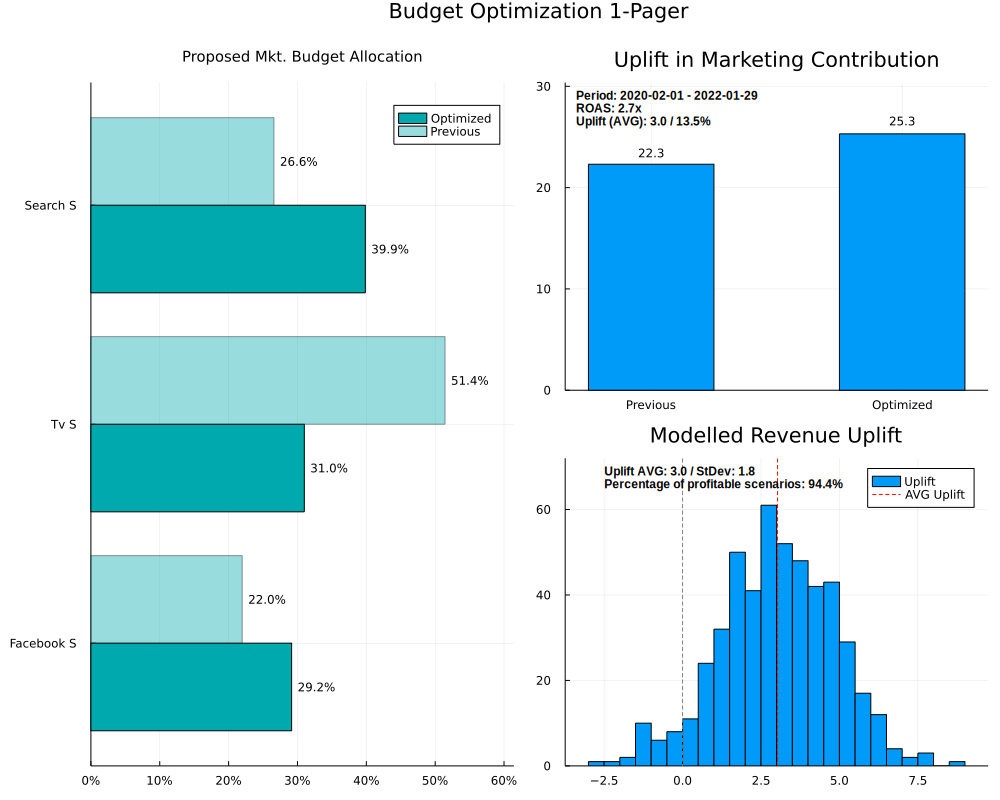

In [125]:
# Header
pl0 = plot(title = "Budget Optimization 1-Pager", grid = false, showaxis = false, ticks=false,bottom_margin = -0Plots.px)


###
spend_share_prev=revert(MinMax(),X_spend,pipe_cache_spend) |> 
    Matrix |> x->@view(x[optim_mask,:]) |> sum_columns |>  percentage_share |> vec
spend_share_optim=revert(MinMax(),X_spend_optim_trf,pipe_cache_spend) |>
    Matrix |> x->@view(x[optim_mask,:]) |> sum_columns |>  percentage_share |> vec

cols=prettify_labels.(cols_spend)

pl1=plot_optimized_spend_share_comparison(spend_share_prev,spend_share_optim,cols,pplot)


### 
effect_prev=hcat([s.mu_spend for s in stage2_fit_allsamples]...) |> x->@view(x[optim_mask,:]) |> x->mean(x,dims=2)|>vec|>sum
effect_optim=mean(spend_effect_trf,dims=2)|>vec|>sum

# Total ROAS 
# TO DO: NOT SUBSET TO OPTIM_MASK!!!
# X_spend_raw_=revert(MinMax(),X_spend_optim_trf,pipe_cache_spend)
X_spend_raw=revert(MinMax(),X_spend,pipe_cache_spend)
roas_total=calc_roas_total(simulations_optim,X_spend_raw) #not subset to optim_mask!

pl2=plot_optimized_contribution(effect_prev,effect_optim,roas_total,optim_start,optim_end,pplot)

###
simulations_optimized_=(simulation_optim_trf|>sum_columns|>vec)
revenue_uplift=revert_pipe_y(simulations_optimized_ .- simulations_prev).y

pl3=plot_optimized_uplift_histogram(revenue_uplift,pplot)

####################
# 1-Pager

plot_array=[pl0,pl1,pl2,pl3]

# Save each step
for i in 1:length(plot_array)
    pl=plot_optimization_one_pager(plot_array,i,pplot)
    # savefig(pl,joinpath(pwd(),"presentation","assets","optimization-1pager_$(i).png"))
end;
# show final
plot_optimization_one_pager(plot_array,4,pplot)

# END